**ETL develping
To prepare sales performance table for further queris and analysis

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("pyspark-mvp").getOrCreate()

df_items = spark.read.csv("gs://pucrio-mvp-sprint3/Brasilian_ecommerce_dataset/olist_order_items_dataset.csv", header=True)
df_products = spark.read.csv("gs://pucrio-mvp-sprint3/Brasilian_ecommerce_dataset/olist_products_dataset.csv", header=True)
df_sellers = spark.read.csv("gs://pucrio-mvp-sprint3/Brasilian_ecommerce_dataset/olist_sellers_dataset.csv", header=True)
df_orders = spark.read.csv("gs://pucrio-mvp-sprint3/Brasilian_ecommerce_dataset/olist_orders_dataset.csv", header=True)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/14 19:15:22 INFO SparkEnv: Registering MapOutputTracker
23/09/14 19:15:22 INFO SparkEnv: Registering BlockManagerMaster
23/09/14 19:15:22 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
23/09/14 19:15:22 INFO SparkEnv: Registering OutputCommitCoordinator


In [4]:
df_items = df_items.fillna('null')
df_products = df_products.fillna('null')
df_sellers = df_sellers.fillna('null')
df_orders = df_orders.fillna('null')

In [5]:
df_products.printSchema()

root
 |-- product_id: string (nullable = false)
 |-- product_category_name: string (nullable = false)
 |-- product_name_lenght: string (nullable = false)
 |-- product_description_lenght: string (nullable = false)
 |-- product_photos_qty: string (nullable = false)
 |-- product_weight_g: string (nullable = false)
 |-- product_length_cm: string (nullable = false)
 |-- product_height_cm: string (nullable = false)
 |-- product_width_cm: string (nullable = false)



In [6]:
df_sellers.printSchema()

root
 |-- seller_id: string (nullable = false)
 |-- seller_zip_code_prefix: string (nullable = false)
 |-- seller_city: string (nullable = false)
 |-- seller_state: string (nullable = false)



In [7]:
df_items.printSchema()

root
 |-- order_id: string (nullable = false)
 |-- order_item_id: string (nullable = false)
 |-- product_id: string (nullable = false)
 |-- seller_id: string (nullable = false)
 |-- shipping_limit_date: string (nullable = false)
 |-- price: string (nullable = false)
 |-- freight_value: string (nullable = false)



In [8]:
df_orders.printSchema()

root
 |-- order_id: string (nullable = false)
 |-- customer_id: string (nullable = false)
 |-- order_status: string (nullable = false)
 |-- order_purchase_timestamp: string (nullable = false)
 |-- order_approved_at: string (nullable = false)
 |-- order_delivered_carrier_date: string (nullable = false)
 |-- order_delivered_customer_date: string (nullable = false)
 |-- order_estimated_delivery_date: string (nullable = false)



In [9]:
trend_analysis = df_items.join(df_orders, df_items.order_id == df_orders.order_id, "inner") \
                        .select(
                        [
                            df_items.order_id.alias("sales_quantity"),
                            df_items.price.alias("revenue"),
                            df_items.freight_value.alias("freight_cost"),
                            df_orders.order_approved_at
                        ]
)


In [10]:
trend_analysis.printSchema()

root
 |-- sales_quantity: string (nullable = false)
 |-- revenue: string (nullable = false)
 |-- freight_cost: string (nullable = false)
 |-- order_approved_at: string (nullable = false)



# trend_analysis table created

In [11]:
from pyspark.sql.types import IntegerType, FloatType, TimestampType
from pyspark.sql.functions import col, year, month
from pyspark.sql import functions as F

trend_analysis = (trend_analysis
                  #.withColumn("sales_quantity", col("sales_quantity").cast(IntegerType()))
                  .withColumn("revenue", col("revenue").cast(FloatType()))
                  .withColumn("freight_cost", col("freight_cost").cast(FloatType()))
                  .withColumn("order_approved_at", col("order_approved_at").cast(TimestampType()))
                 )

trend_analysis = (trend_analysis
                  .withColumn("month_year", F.trunc("order_approved_at", "MM"))
                 )

In [12]:
trend_analysis.printSchema()

root
 |-- sales_quantity: string (nullable = false)
 |-- revenue: float (nullable = true)
 |-- freight_cost: float (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- month_year: date (nullable = true)



In [13]:
# 繪圖要有別名
monthly_analysis = trend_analysis.groupBy("month_year").agg(
                F.count("sales_quantity").alias("Sales Quantity"),
                F.sum("revenue").alias("Revenue"),
                F.sum("freight_cost").alias("Freight Cost")
)

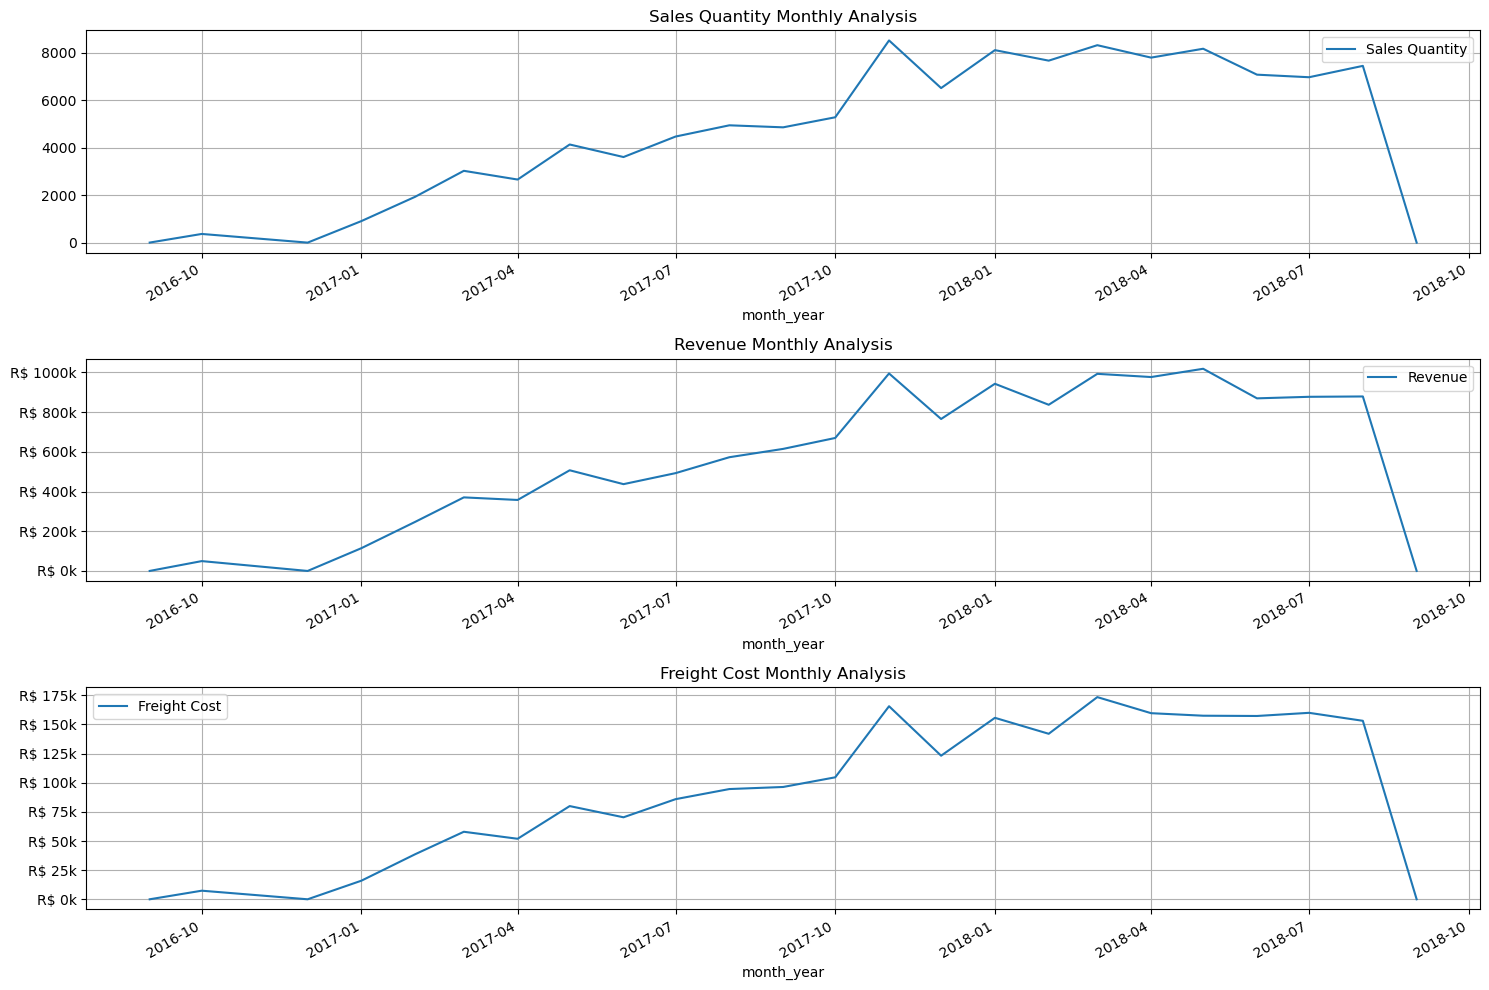

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# 將 PySpark DataFrame 轉換為 Pandas DataFrame
monthly_data_pd = monthly_analysis.toPandas()
monthly_data_pd['month_year'] = pd.to_datetime(monthly_data_pd['month_year'])
monthly_data_pd = monthly_data_pd.sort_values('month_year')

# 繪製圖表
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
monthly_data_pd.plot(x='month_year', y='Sales Quantity', ax=axes[0], title='Sales Quantity Monthly Analysis', grid=True)
monthly_data_pd.plot(x='month_year', y='Revenue', ax=axes[1], title='Revenue Monthly Analysis', grid=True)
monthly_data_pd.plot(x='month_year', y='Freight Cost', ax=axes[2], title='Freight Cost Monthly Analysis', grid=True)

# 調整 y 軸標籤
axes[1].yaxis.set_major_formatter(lambda x, _: f'R$ {x*1e-3:.0f}k')
axes[2].yaxis.set_major_formatter(lambda x, _: f'R$ {x*1e-3:.0f}k')

plt.tight_layout()
plt.show()

*-----------------------------------------------------------------------------------

In [28]:
df1 = df_items.join(df_products, df_items.product_id == df_products.product_id, "inner") \
            .select(
            [
                df_items.order_id,
                df_items.product_id,
                df_items.seller_id,
                df_products.product_category_name,
                df_items.price,
                df_items.shipping_limit_date
            ]
)

sales_performance = df1.join(df_sellers, df1.seller_id == df_sellers.seller_id, "inner") \
                .select(
                [
                    df1.order_id,
                    df1.product_id,
                    df1.seller_id,
                    df1.product_category_name,
                    df1.price,
                    df1.shipping_limit_date,
                    df_sellers.seller_state
                ]
)

In [29]:
sales_performance.printSchema()

root
 |-- order_id: string (nullable = false)
 |-- product_id: string (nullable = false)
 |-- seller_id: string (nullable = false)
 |-- product_category_name: string (nullable = false)
 |-- price: string (nullable = false)
 |-- shipping_limit_date: string (nullable = false)
 |-- seller_state: string (nullable = false)



# sales_performance table created

In [30]:
from pyspark.sql.types import IntegerType, FloatType, TimestampType
from pyspark.sql.functions import col, year

sales_performance = (sales_performance
                  .withColumn("price", col("price").cast("Float"))
                  .withColumn("shipping_limit_date", col("shipping_limit_date").cast(TimestampType()))
                  
                 )

In [32]:
sales_performance.printSchema()

root
 |-- order_id: string (nullable = false)
 |-- product_id: string (nullable = false)
 |-- seller_id: string (nullable = false)
 |-- product_category_name: string (nullable = false)
 |-- price: float (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- seller_state: string (nullable = false)



**Analysis case 1: Identify the best and worst-performing sellers

In [31]:
seller_ranking = sales_performance.withColumn("shipping_year", year(sales_performance.shipping_limit_date))

seller_ranking.printSchema()

root
 |-- order_id: string (nullable = false)
 |-- product_id: string (nullable = false)
 |-- seller_id: string (nullable = false)
 |-- product_category_name: string (nullable = false)
 |-- price: float (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- seller_state: string (nullable = false)
 |-- shipping_year: integer (nullable = true)



In [22]:
from pyspark.sql import functions as F

seller_performance = seller_ranking.groupBy("seller_id", "shipping_year", "seller_state").agg(
                    F.count("order_id").alias("total_orders"),
                    F.round(F.sum("price"), 2).alias("total_revenue")
)

In [27]:
seller_performance.printSchema()

root
 |-- seller_id: string (nullable = false)
 |-- shipping_year: integer (nullable = true)
 |-- seller_state: string (nullable = false)
 |-- total_orders: long (nullable = false)
 |-- total_revenue: double (nullable = true)



In [23]:
seller_performance.show()

+--------------------+-------------+------------+------------+-------------+
|           seller_id|shipping_year|seller_state|total_orders|total_revenue|
+--------------------+-------------+------------+------------+-------------+
|ef506c96320abeedf...|         2018|          SP|          71|      2006.66|
|a3b0df0065e264a91...|         2017|          SP|           2|       186.69|
|30a2f535bb48308f9...|         2017|          SP|          46|       2495.4|
|dc4a0fc896dc34b0d...|         2018|          SP|          41|      3683.46|
|3935fe5fe0f82787a...|         2018|          SP|          17|      1681.69|
|e0a366315b1b726b6...|         2017|          SP|          12|      1598.89|
|f3da5b2ff499efb8d...|         2017|          SP|          15|       822.66|
|575df70bde3f9f2b3...|         2016|          SP|           2|        399.8|
|86ff3eaef0267069c...|         2018|          SC|           7|       409.75|
|c286ec035ee04ba81...|         2017|          PR|           2|        493.0|

In [25]:

from pyspark.sql.functions import row_number, rank
from pyspark.sql.window import Window


windowSpec_revenue = Window.partitionBy(["shipping_year"]) \
                            .orderBy(F.desc(seller_performance.total_revenue))

windowSpec_num_orders = Window.partitionBy(["shipping_year"]) \
                                .orderBy(F.desc(seller_performance.total_orders))


sellers_ranking_by_revenue_by_year = (seller_performance
                                      .withColumn("rank", rank().over(windowSpec_revenue))
                                      .orderBy(["shipping_year", "rank"], ascending=True)
)

sellers_ranking_by_order_by_year = (seller_performance
                                      .withColumn("rank", rank().over(windowSpec_num_orders))
                                      .orderBy(["shipping_year", "rank"], ascending=True)
)


sellers_ranking_by_revenue_by_year.show()


+--------------------+-------------+------------+------------+-------------+----+
|           seller_id|shipping_year|seller_state|total_orders|total_revenue|rank|
+--------------------+-------------+------------+------------+-------------+----+
|620c87c171fb2a6dd...|         2016|          RJ|          29|       5797.1|   1|
|822b63912576852ae...|         2016|          SP|           3|      2849.97|   2|
|46dc3b2cc0980fb8e...|         2016|          RJ|          11|      2344.89|   3|
|4d600e08ecbe08258...|         2016|          PR|           3|      1931.34|   4|
|ed859002ad59dbf8c...|         2016|          PR|          10|       1702.0|   5|
|76d5af76d0271110f...|         2016|          SP|           3|       1447.0|   6|
|7e93a43ef30c4f03f...|         2016|          SP|           1|       1399.0|   7|
|ecccfa2bb93b34a3b...|         2016|          PR|          19|      1338.64|   8|
|87b740daf17b5d1be...|         2016|          SP|           1|      1299.99|   9|
|86bb7c4b535e49a

In [26]:
sellers_ranking_by_order_by_year.show()

+--------------------+-------------+------------+------------+-------------+----+
|           seller_id|shipping_year|seller_state|total_orders|total_revenue|rank|
+--------------------+-------------+------------+------------+-------------+----+
|620c87c171fb2a6dd...|         2016|          RJ|          29|       5797.1|   1|
|ecccfa2bb93b34a3b...|         2016|          PR|          19|      1338.64|   2|
|cca3071e3e9bb7d12...|         2016|          SP|          13|        953.7|   3|
|391fc6631aebcf300...|         2016|          SP|          13|       916.23|   3|
|46dc3b2cc0980fb8e...|         2016|          RJ|          11|      2344.89|   5|
|ed859002ad59dbf8c...|         2016|          PR|          10|       1702.0|   6|
|897060da8b9a21f65...|         2016|          SP|          10|        801.3|   6|
|d101c6da914ae3d53...|         2016|          SP|           7|        446.3|   8|
|1554a68530182680a...|         2016|          MG|           7|       325.84|   8|
|b17b679f4f5ce2e

In [34]:
sellers_ranking_by_revenue_by_year_top10 = sellers_ranking_by_revenue_by_year.filter("rank <= 5")

sellers_ranking_by_revenue_by_year_top10.show()

+--------------------+-------------+------------+------------+-------------+----+
|           seller_id|shipping_year|seller_state|total_orders|total_revenue|rank|
+--------------------+-------------+------------+------------+-------------+----+
|620c87c171fb2a6dd...|         2016|          RJ|          29|       5797.1|   1|
|822b63912576852ae...|         2016|          SP|           3|      2849.97|   2|
|46dc3b2cc0980fb8e...|         2016|          RJ|          11|      2344.89|   3|
|4d600e08ecbe08258...|         2016|          PR|           3|      1931.34|   4|
|ed859002ad59dbf8c...|         2016|          PR|          10|       1702.0|   5|
|53243585a1d6dc264...|         2017|          BA|         255|    176685.92|   1|
|7e93a43ef30c4f03f...|         2017|          SP|         283|    159010.13|   2|
|4a3ca9315b744ce9f...|         2017|          SP|        1225|    126450.27|   3|
|46dc3b2cc0980fb8e...|         2017|          RJ|         462|    109056.99|   4|
|fa1c13f2614d7b5

**Analysis case 2: Identify the best and worst-performing sellers

In [35]:
# 對產品類別和order_id進行分組，計算每個產品類別的訂單數量和總收入。
product_category_performance = sales_performance.groupBy("product_category_name").agg(
    F.count("order_id").alias("total_orders"),
    F.round(F.sum("price"), 2).alias("total_revenue")
)

# 按照訂單數量和總收入進行排序，以瞭解最受歡迎的產品類別。
product_category_performance_sorted_by_orders = product_category_performance.orderBy(F.desc("total_orders"))
product_category_performance_sorted_by_revenue = product_category_performance.orderBy(F.desc("total_revenue"))

# 顯示結果
product_category_performance_sorted_by_orders.show(5)
product_category_performance_sorted_by_revenue.show(5)

+---------------------+------------+-------------+
|product_category_name|total_orders|total_revenue|
+---------------------+------------+-------------+
|      cama_mesa_banho|       11115|   1036988.68|
|         beleza_saude|        9670|   1258681.34|
|        esporte_lazer|        8641|    988048.97|
|     moveis_decoracao|        8334|    729762.49|
| informatica_acess...|        7827|    911954.32|
+---------------------+------------+-------------+
only showing top 5 rows



+---------------------+------------+-------------+
|product_category_name|total_orders|total_revenue|
+---------------------+------------+-------------+
|         beleza_saude|        9670|   1258681.34|
|   relogios_presentes|        5991|   1205005.68|
|      cama_mesa_banho|       11115|   1036988.68|
|        esporte_lazer|        8641|    988048.97|
| informatica_acess...|        7827|    911954.32|
+---------------------+------------+-------------+
only showing top 5 rows

